 人口密度を使った検証モデル
 
1. NTTdokomoが提供する、都市間での人口密度の比較データとSARIMA予測を用いたデータを統合することによって感染者数の推移を調べる。
 
2. モデルの考え方
        - ①. 緊急事態宣言によって、都市での人口密度がコロナの感染者数の推移に影響を与えたものと考える。
        - ②. 元のデータの感染者数と、人口密度によって新規感染者数が決まると考える。
        - ③. 新規感染者数はM日前の感染者数に依存する。
		      NTTdocomoが提供している、都道府県別の東京 新宿駅の人口密度増加率を使用する。
		      この値は緊急事態宣言によって、人口密度の減少を表す代表値と考える。
       - ④. SARIMAモデルの予測データと、人口密度のデータを合成する事で、仮説が正しいかどうか判別する。

In [1]:
"""
新規コロナウィルス感染者数を予測するプログラム

新規感染者数のデータを使用
都市部の人口密度を使用
"""
import os
import numpy as np
import pandas as pd

from pulp import *

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import datetime
import time

import warnings
warnings.filterwarnings("ignore")

使用するデータの読み込み
    NTTdokomoが提供する都市間での人口密度の　前年比　と　昨日との比較　を読み込む

In [2]:
# csvファイルの読み込み
DATA = pd.read_csv("Population.csv")

print("Population .shape ", DATA.shape)
DATA

Population .shape  (81, 5)


,日付,感染拡大以前との比較,前日との比較,宣言前（７日)と比較,新規感染者数
0,4月18日,-80.2,-33.1,-68.3,589
1,4月19日,-79.9,1.3,-67.9,376
2,4月20日,-69.2,40.9,-54.8,345
3,4月21日,-69.7,-1.4,-55.4,391
4,4月22日,-69.3,1.1,-55.0,442
5,4月23日,-69.7,-1.3,-55.5,435
6,4月24日,-68.3,4.6,-53.5,442
7,4月25日,-78.9,-27.5,-66.3,382
8,4月26日,-81.9,-14.3,-71.1,220
9,4月27日,-70.2,51.3,-56.3,174


In [3]:
# 移動平均による平滑化

# DATA['day¥']=DATA['DAY']
# DATA['last_year_density'] = DATA['p-i'].rolling(7).sum()/7 #感染拡大以前との比較
# DATA['yesterday_density'] = DATA['yesterday-p-i'].rolling(7).sum()/7 #前日との比較
# DATA['new_p'] = DATA['new-p'].rolling(7).sum()/7
# print(DATA)

In [4]:
# 感染拡大以前との比較　および　前日との比較　の移動平均の表示
# print('10 : ',DATA['day'].loc[10])
# print('20 : ',DATA['day'].loc[20])
# print('30 : ',DATA['day'].loc[30])
# print('40 : ',DATA['day'].loc[40])

# DF_plot=DATA.copy()

# DF_plot=DF_plot[['last_year_density','yesterday_density']]
# DATA=DATA[['p-i','yesterday-p-i','new-p']]

# DATA.plot()
# DF_plot.plot()

In [5]:
# モデルの計算、計算結果の保存用のデータフレームにコピー
DF=DATA.copy()
DF['day']=DF['日付']
DF['last_year_density'] = DF['感染拡大以前との比較'].rolling(7).sum()/7 #感染拡大以前との比較
DF['last_year_density'] = DF['last_year_density']/-100 # %を変換
DF['yesterday_density'] = DF['前日との比較'].rolling(7).sum()/7 #前日との比較
DF['new_p'] = DF['新規感染者数'].rolling(7).sum()/7
DF

,日付,感染拡大以前との比較,前日との比較,宣言前（７日)と比較,新規感染者数,day,last_year_density,yesterday_density,new_p
0,4月18日,-80.2,-33.1,-68.3,589,4月18日,NaN,NaN,NaN
1,4月19日,-79.9,1.3,-67.9,376,4月19日,NaN,NaN,NaN
2,4月20日,-69.2,40.9,-54.8,345,4月20日,NaN,NaN,NaN
3,4月21日,-69.7,-1.4,-55.4,391,4月21日,NaN,NaN,NaN
4,4月22日,-69.3,1.1,-55.0,442,4月22日,NaN,NaN,NaN
5,4月23日,-69.7,-1.3,-55.5,435,4月23日,NaN,NaN,NaN
6,4月24日,-68.3,4.6,-53.5,442,4月24日,0.723286,1.728571,431.428571
7,4月25日,-78.9,-27.5,-66.3,382,4月25日,0.721429,2.528571,401.857143
8,4月26日,-81.9,-14.3,-71.1,220,4月26日,0.724286,0.300000,379.571429
9,4月27日,-70.2,51.3,-56.3,174,4月27日,0.725714,1.785714,355.142857


In [6]:
# 新規感染者数を推測するモデルを学習させるクラス

optim_num=20000    # 最適化計算をする回数 

X_list=np.array([[0,20, 0.6 , 5.910],[10,20 , 1.5 , 11],[8,30, 1.5, 13],[-1,10, 0.4 , 1.8705],[-1,10,0.4,0.84210]])
   # 最適化するパラメータ[a,N,M,r,s] の　範囲（最小、最大）と刻み、初期値
     
column_list=['new_p','last_year_density','inf']  # データフレーム中　使用する変数
#　最後のリストは予測値を入れる列

idx_last=73    # 最適化に使用するデータの最大値、最小値
idx_start=20   

class Optimizer:
    """
    予測モデル、予測値を計算する。
    予測モデルを複数回十国することにより最適化を行う
        
    """
    def __init__(self,
                 DF = DF,                 # 使用するデータフレーム　idxで値を呼び出す
                 X_list=X_list,            #  最適化する　パラメータ
                 idx_last=idx_last,        #  学習に使用する最終idx
                 idx_start=idx_start,      #　学習に使用する最初のidx
                 column_list=column_list,  #　使用する　列名リスト
                 optim_num=optim_num       #  学習回数
                 ):
        """
        初期値の設定
        
        Argments:
            DF (object): 使用するデータフレーム
            X_list (list): 最適化するパラメータの範囲と刻み、初期値
            idx_start (int): 学習に使用するデータフレームの最初のidx
            idx_last (int): 学習に使用するデータフレームの最後のidx
            column_list (list): データフレームの中から使用するデータを決める列名リスト
            obtim_naum (list): 学習回数
        Returns:
            なし。
        """

        
        self.DF=DF
        self.X_list=X_list
        self.idx_start=idx_start
        self.idx_last=idx_last
        self.column_list=column_list
        self.optim_num=optim_num
        
        
    def Pred_y(self,X,idx):  # 予測モデル X:モデルのパラメータ　idx：求める日にちに相当
        inf = ((self.DF[self.column_list[0]].loc[idx-X[1]]+
                self.DF[self.column_list[0]].loc[idx-X[1]-1])+
               self.DF[self.column_list[0]].loc[idx-X[1]-2]/3)**X[4]  # 感染者数　項(変動大きいので３日分の平均)
        cont = self.DF[self.column_list[1]].loc[idx-X[2]]**X[3]       # 接触頻度　項
        Pred_y = X[0] * inf * cont
    
        return Pred_y
    
    def calc_loss(self,X):    # 指定範囲のデータを用いてモデルの予測誤差を計算
        loss=0
        for idx in range(self.idx_start,self.idx_last):
            T=self.DF[self.column_list[0]].loc[idx]  # 正解
            P = self.Pred_y(X,idx)                   # 予測値
            loss += np.abs(T-P)
            #loss += np.square(T-P)
        return loss/(self.idx_last-self.idx_start)
    
    def X_valid(self,X): # 乱数により　X　の値を制約の中でシフトさせ　新たなXを発生させる
        rand=(np.random.rand(len(self.X_list)) -0.5)*2      # -1～1の乱数を５個発生
        dx=X_list[:,2]*rand                              # Xの変化幅
        dx[1:3]=np.round(dx[1:3])                        # 整数値が必要な項目の処理 
        X=X+dx                                           # 差分を元のXに加える
        X=np.clip(X,self.X_list[:,0],self.X_list[:,1])   #  X_listで定義された最大最小値内にクリップ
        return X
    
    def closing(self,X):    # 終了処理　最終モデルの予測データの保存　グラフ化
        self.DF[self.column_list[2]]='NaN'
        for idx in range(self.idx_start,self.idx_last+int(min(X[1],X[2]))):# 学習済みモデルで予測・保存
            P = self.Pred_y(X,idx)
            self.DF[self.column_list[2]].loc[idx]=P
            
        DF_plot=self.DF[self.column_list].loc[self.idx_start:self.idx_last]
        DF_plot[self.column_list[1]]=DF_plot[self.column_list[1]]*500
        DF_plot.plot()
        return self.DF
        
        
    def optim(self):         # 最適化処理　loss　minとなるパラメータを探す
        X=self.X_list[:,3]#　初期値
        X_min=X
        loss_min=self.calc_loss(X)
        for i in range(self.optim_num):
            if i%5000==0:
                print('loss',loss_min,X_min,i)
            X=self.X_valid(X_min)
            loss = self.calc_loss(X)
            if loss<loss_min :
                X_min=X
                loss_min=loss
                #print('loss',loss,X,i)
        DF = self.closing(X_min)
        print('')
        print('loss',loss_min,X_min)
        return X_min , DF

loss 229.2583734483274 [ 5.91   11.     13.      1.8705  0.8421] 0
loss 9.219097532492224 [ 2.66312529 10.         11.         -1.          0.49900358] 5000
loss 9.098275794191226 [ 2.55499964 10.         10.         -1.          0.50689759] 10000
loss 9.09512425925736 [ 2.53091729 10.         10.         -1.          0.50819818] 15000

loss 9.09512425925736 [ 2.53091729 10.         10.         -1.          0.50819818]
CPU times: user 4min 12s, sys: 2.79 s, total: 4min 15s
Wall time: 4min 29s


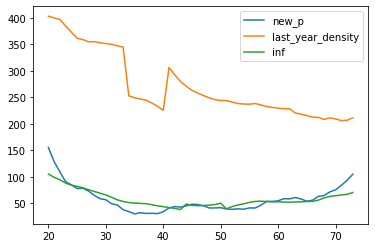

In [7]:
%%time
# クラスを使い　モデルのパラメータを学習させる

Opti=Optimizer()
optim_X,DF00=Opti.optim()

# 新規感染者数の移動平均と数学モデルで推測した値をグラフで表示

In [9]:
DF00

,日付,感染拡大以前との比較,前日との比較,宣言前（７日)と比較,新規感染者数,day,last_year_density,yesterday_density,new_p,inf
0,4月18日,-80.2,-33.1,-68.3,589,4月18日,NaN,NaN,NaN,NaN
1,4月19日,-79.9,1.3,-67.9,376,4月19日,NaN,NaN,NaN,NaN
2,4月20日,-69.2,40.9,-54.8,345,4月20日,NaN,NaN,NaN,NaN
3,4月21日,-69.7,-1.4,-55.4,391,4月21日,NaN,NaN,NaN,NaN
4,4月22日,-69.3,1.1,-55.0,442,4月22日,NaN,NaN,NaN,NaN
5,4月23日,-69.7,-1.3,-55.5,435,4月23日,NaN,NaN,NaN,NaN
6,4月24日,-68.3,4.6,-53.5,442,4月24日,0.723286,1.728571,431.428571,NaN
7,4月25日,-78.9,-27.5,-66.3,382,4月25日,0.721429,2.528571,401.857143,NaN
8,4月26日,-81.9,-14.3,-71.1,220,4月26日,0.724286,0.300000,379.571429,NaN
9,4月27日,-70.2,51.3,-56.3,174,4月27日,0.725714,1.785714,355.142857,NaN


In [10]:
# 学習したパラメータを入れたモデルを用い　感染者数の移動平均を予測する
#　　学習に用いた日にちより後の予測を行う
column_list[1]='last_year_density'    # 使用する接触頻度特性

pred_last = 80 # 予測を行う　最終行数

Opti=Optimizer(DF=DF00)   # 新たなデータでクラスを立ち上げ直す
for idx in range(idx_last-1,pred_last):
    DF00['inf'].loc[idx]=Opti.Pred_y(optim_X,idx)    # 予測結果を保存
    DF00['new_p'].loc[idx]=Opti.Pred_y(optim_X,idx)  #　予測結果を予測に使う列に追加

#DF00[130:165]

10 :  4月28日
30 :  5月18日
50:  6月7日
70:  6月27日


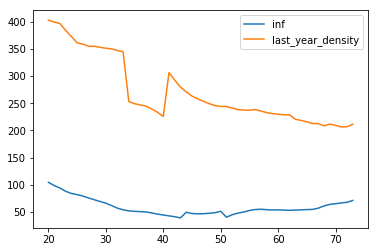

In [11]:
#　新規感染者数の予測結果と　使用した接触頻度特性を表示
print('10 : ',DF00['day'].loc[10])
print('30 : ',DF00['day'].loc[30])
print('50: ',DF00['day'].loc[50])
print('70: ',DF00['day'].loc[70])

DF_plot=DF00[['inf',column_list[1]]].loc[idx_start:73]
DF_plot[column_list[1]]=DF_plot[column_list[1]]*500

DF_plot.plot()

In [13]:
#  感染者数を入れる列の追加
DF00['inf_2']='NaN'
DF00['T_inf']=DF00['新規感染者数']

In [14]:
# 移動平均から各曜日の値に戻す関数
monday_idx=74     # 月曜日のidx
coef_list=[0.593, 0.9237, 1.081, 1.112, 1.189 ,1.199, 0.851]   # 曜日ごとの係数　別途計算した
week=['月','火','水','木','金','土','日']

def calc_inf_num(idx):
    week_idx = (idx-monday_idx)% 7
    #print(week_idx)
    #print(week[week_idx])
    val=DF00['new_p'].loc[idx+3]*coef_list[week_idx]
    return val

10 :  4月28日
30 :  5月18日
50 :  6月7日
70 :  6月27日


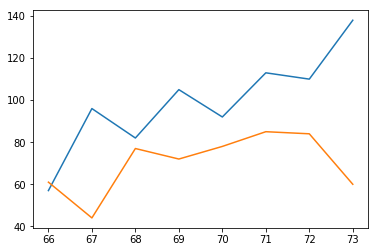

In [41]:
#  元に戻す関数を使用し　感染者数の移動平均から 新規感染者数　累積感染者数を求める

lastID=78             # この処理を行う最後の行番号
last_T_PCR_p=idx_last+1 # 累計計算のスタート点  最後の累計計測値データ

for idx in range(idx_start,lastID):
    DF00['inf_2'].loc[idx]=int(calc_inf_num(idx))

#  感染者数の累積を計算する  
DF00['T_inf'].loc[last_T_PCR_p]=DF00['新規感染者数'].loc[last_T_PCR_p]   

for idx in range(idx_last+1,lastID):
    DF00['T_inf'].loc[idx]=DF00['T_inf'].loc[idx-1]+DF00['inf_2'].loc[idx]
    
#  感染者数の累積を表示する   
print('10 : ',DF00['day'].loc[10])
print('30 : ',DF00['day'].loc[30])
print('50 : ',DF00['day'].loc[50])
print('70 : ',DF00['day'].loc[70])



# DF_plot=DF00['T_inf'].loc[idx_start:lastID-1]
DF_plot=DF00['T_inf'].loc[66:73]
DF_plot.plot(label="新規感染者数")
# DF_plot=DF00['inf_2'].loc[idx_start:lastID-1]
DF_plot=DF00['inf_2'].loc[66:73]
DF_plot.plot(label="新規予測感染者数")


In [17]:
from sklearn.metrics import r2_score

In [18]:
# 予測したい日のデータをコピー
X = DF00[["T_inf"]]
X = pd.Series(X[1:]["T_inf"],dtype = "float64")
X = X[74:80]
Y = DF00[["inf_2"]]
Y = pd.Series(Y[1:]["inf_2"],dtype = "float64")
Y = Y.fillna(0)
Y = Y[74:80]
print(X)
print(Y)

print(r2_score(X,Y))

75    252.0
76    336.0
77    564.0
78    208.0
79    176.0
80    211.0
Name: T_inf, dtype: float64
75     71.0
76     84.0
77    228.0
78      0.0
79      0.0
80      0.0
Name: inf_2, dtype: float64
-2.135344276715328
